In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from itertools import permutations
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.linear_model import LinearRegression
import difflib
from moviepy.editor import *
from IPython.display import display, HTML
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})
display(HTML("<style>.container { width:85% !important; }</style>"))

c:\Users\Jorge\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Inits

In [2]:
# full_data = pd.read_pickle('fully_labeled_traces_smoothedLabels_120423_nonznorm.pickle')
# full_data = pd.read_pickle('E:\\fully_labeled_traces_smoothedLabels_031024.pickle')
full_data = pd.read_pickle('fully_labeled_traces_feats3_042224.pickle')
# fuller_data = pd.read_pickle('C:\\Users\\Jorge\\Documents\\PythonScripts\\data4EI.pickle')

# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
clusters = np.unique(full_data['91R2_d1_balbc_t1']['unsupervised labels'])
print(clusters)
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '87L2', '86L']
non_animals = ['87R2', '87B', '87L', '86L2']

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [3]:
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties

    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=50000, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting

    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]

    return z

In [23]:
def save_dict_as_pickle(dictionary, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(dictionary, f)

baseline_corrected_data = full_data.copy()
from tqdm import tqdm

for key in tqdm(baseline_corrected_data.keys()):
    for region in region_ids:
        corrected_trace = baseline_corrected_data[key][region].values
        if np.isnan(corrected_trace).any():
            continue
        corrected_trace -= airPLS(corrected_trace, lambda_=100000, porder=2)
        baseline_corrected_data[key][region] = corrected_trace

save_dict_as_pickle(baseline_corrected_data, 'fully_labeled_traces_feats3_042224_baseline_corrected.pickle')

100%|██████████| 540/540 [11:47<00:00,  1.31s/it]


AttributeError: 'dict' object has no attribute 'to_pickle'

In [4]:
full_data =pd.read_pickle('fully_labeled_traces_feats3_042224_baseline_corrected.pickle')

In [158]:
from scipy.stats import zscore

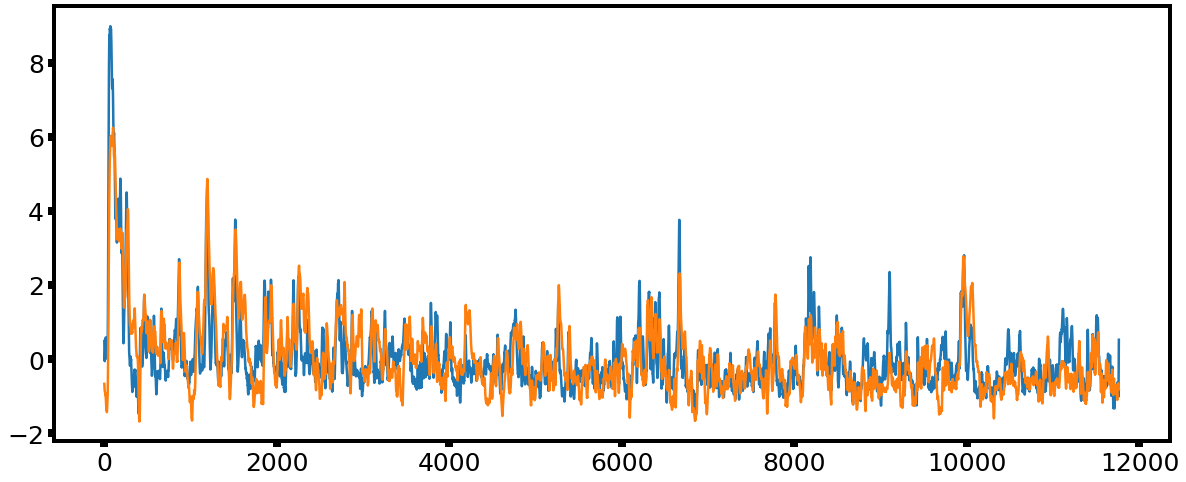

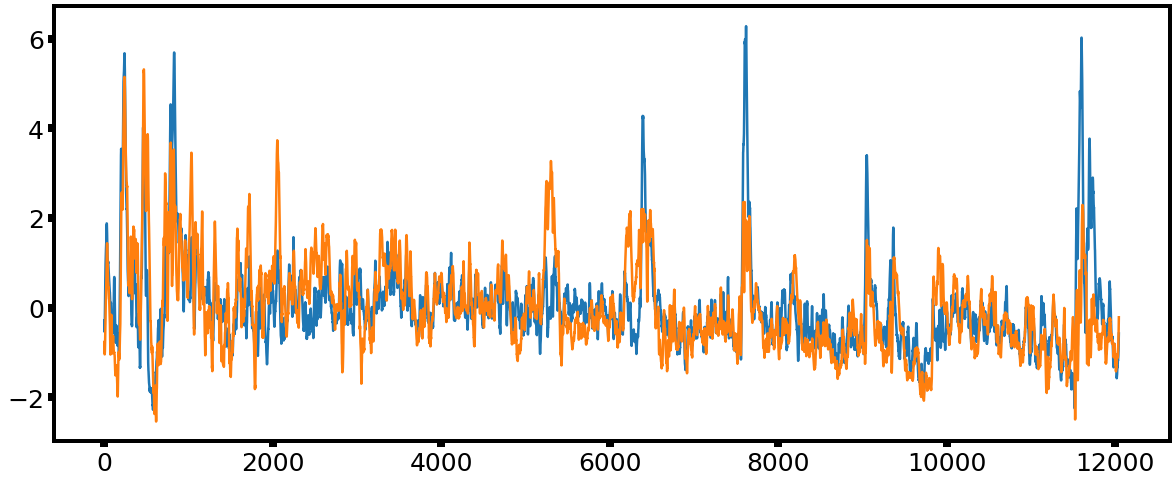

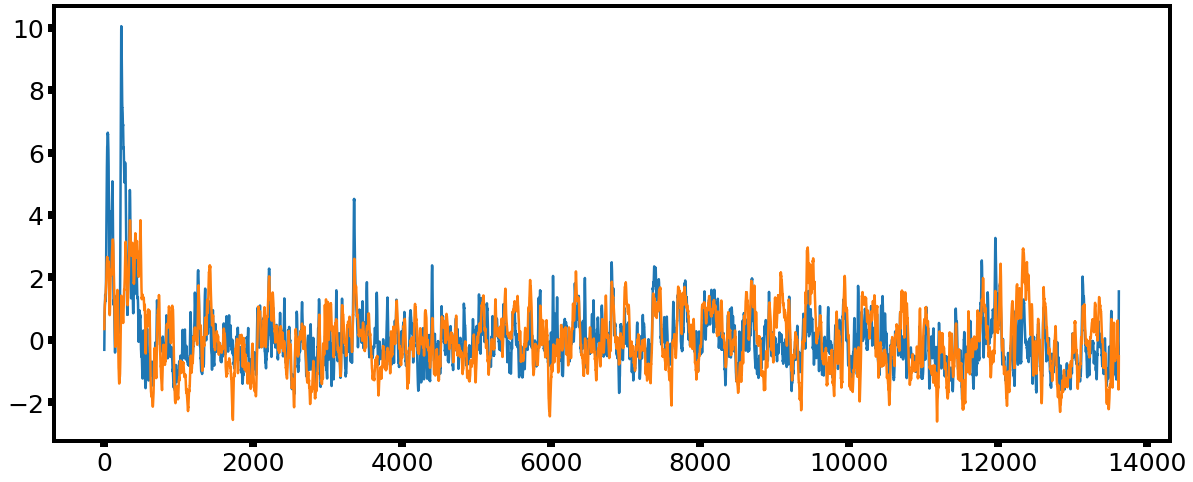

In [189]:
animal_ID = '87B'
roi = 'AH'

plt.figure(figsize=(20, 8))
plt.plot(zscore(full_data['%s_d9_toyCD1_t1' % animal_ID]['%s (E)' % roi].values)) 
plt.plot(zscore(full_data['%s_d9_toyCD1_t1' % animal_ID]['%s (I)' % roi].values)) 

plt.figure(figsize=(20, 8))
plt.plot(zscore(full_data['%s_d9_toyCD1_t2' % animal_ID]['%s (E)' % roi].values)) 
plt.plot(zscore(full_data['%s_d9_toyCD1_t2' % animal_ID]['%s (I)' % roi].values)) 

plt.figure(figsize=(20, 8))
plt.plot(zscore(full_data['%s_d9_toyCD1_t3' % animal_ID]['%s (E)' % roi].values)) 
plt.plot(zscore(full_data['%s_d9_toyCD1_t3' % animal_ID]['%s (I)' % roi].values)) 

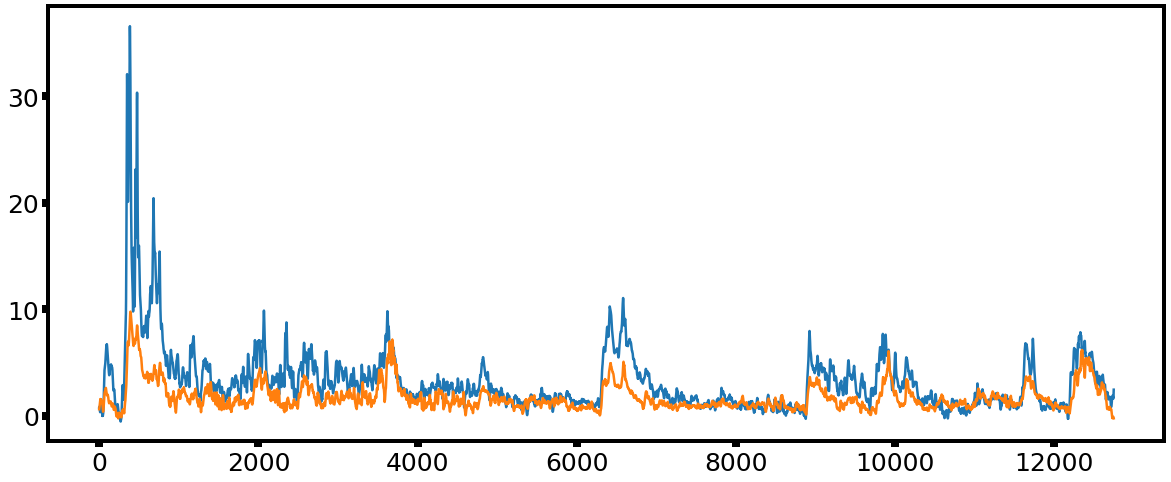

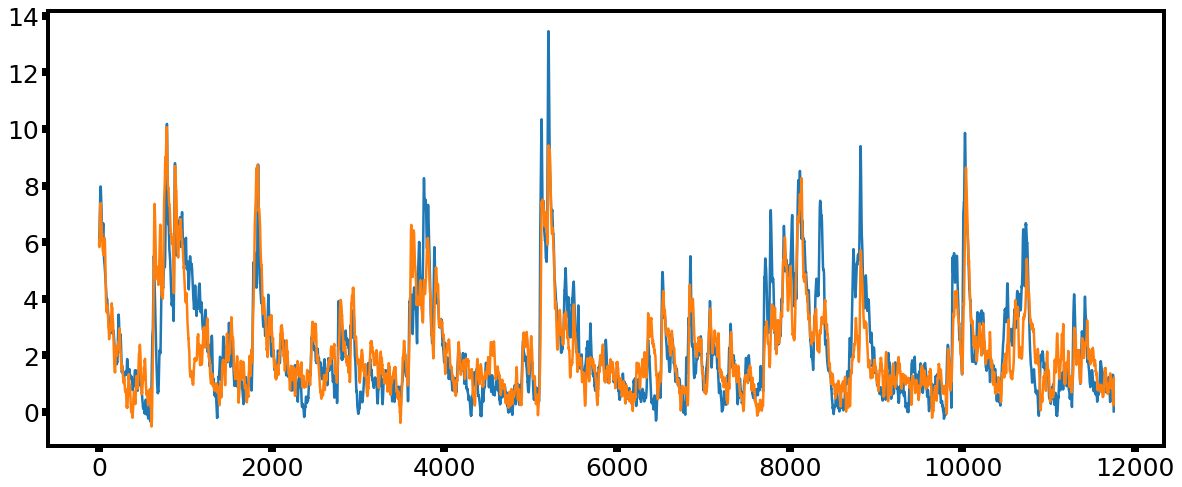

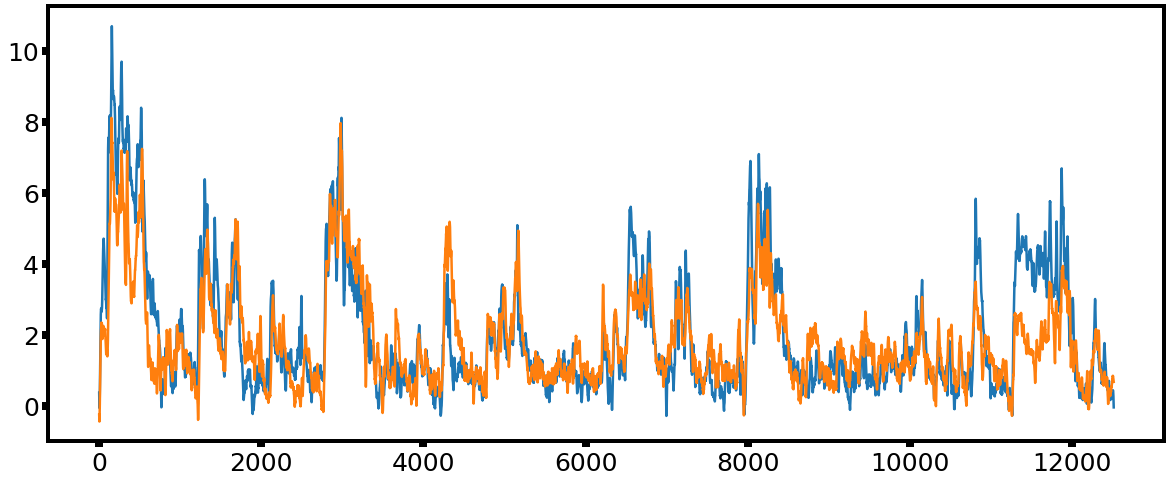

In [193]:
animal_ID = '86L2'
roi = 'AH'

plt.figure(figsize=(20, 8))
plt.plot(full_data['%s_d9_toyCD1_t1' % animal_ID]['%s (E)' % roi].values)
plt.plot(full_data['%s_d9_toyCD1_t1' % animal_ID]['%s (I)' % roi].values)

plt.figure(figsize=(20, 8))
plt.plot(full_data['%s_d9_toyCD1_t2' % animal_ID]['%s (E)' % roi].values)
plt.plot(full_data['%s_d9_toyCD1_t2' % animal_ID]['%s (I)' % roi].values)

plt.figure(figsize=(20, 8))
plt.plot(full_data['%s_d9_toyCD1_t3' % animal_ID]['%s (E)' % roi].values)
plt.plot(full_data['%s_d9_toyCD1_t3' % animal_ID]['%s (I)' % roi].values)

In [185]:
### run ranking computation on aggressive experience
animals = np.concatenate([agg_animals, obs_animals, non_animals])
all_activity = np.zeros((len(clusters), len(region_ids), 27, len(animals)))
all_activity[:] = np.nan

for a, animal in enumerate(animals):
    
    if a<=11:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
    elif a<=15:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_toy_' in x or '_toyCD1_' in x]
        
    for s, session in enumerate(sessions):
        
        sample = full_data[session]
        activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

        for i, c in enumerate(clusters):
            idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
            for r, roi in enumerate(region_ids):
                if len(idxs2extract)==0:
                    activity_per_cluster[i, r] = 0
                else:
                    activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])

        # Perform ranking
        all_activity[:, :, s, a] = activity_per_cluster
        

### Goal: to determine whether activity changes longitudinally as a function of day and session


Step 1. LM model -- we model photometry activity across days using time-related inputs: 1) the order of days, and 2) the order of sessions within each day

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [236]:
def fit_model(df, predictors):

    results = {}

    # Create the formula
    formula = "dependent_variable ~ " + " + ".join(predictors)

    # Create a mixed linear model using smf.mixedlm
    mixed_lm = smf.mixedlm(
        formula=formula,
        groups="subject",
        data=df
    )

    # Fit the model
    mixed_lm_fit = mixed_lm.fit()
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('error', category=ConvergenceWarning)
            results = mixed_lm.fit()
            print("Model converged.")
    except ConvergenceWarning:
        print("Model did not converge.")
    

    # Derive the predicted data
    predicted_data = mixed_lm_fit.predict()

    # Print the summary of the model
    # print(mixed_lm_fit.summary())
    
    return mixed_lm_fit, predicted_data

def compute_EI(grid, n_clusters, n_animals=12):

    EI_grid = np.zeros((len(n_clusters), 11, grid.shape[2], n_animals))
    EI_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]): # E indices
            exc = grid[n_clusters, idx, :, a] # if clusters are selected monotonically
            inh = grid[n_clusters, idx+1, :, a] # if clusters are selected monotonically
            EI_grid[:, i, :, a] = (exc-inh) / np.nanmean(exc+inh)

    return EI_grid

def vector_difference(vector1, vector2):
    """
    Calculate the vector difference between two vectors.

    Parameters:
    - vector1: NumPy array or list, the first vector.
    - vector2: NumPy array or list, the second vector.

    Returns:
    - difference: Vector difference (vector1 - vector2).
    """
    # Convert the input vectors to NumPy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    # Calculate the vector difference
    difference = vector1 - vector2

    return np.mean(difference)

dist_func = vector_difference

# For computing EI indices
n_clusters = [1, 2, 3, 4]
total_sessions = 27
n_rois = 11

# ALL
n_animals = 22
EI_data = np.zeros((len(n_clusters), n_rois, 27, n_animals)) # modify the animals here
EI_data[:, :, :,:] = compute_EI(all_activity[:, :, :, :], n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, n_rois, n_animals))
all_dists[:] = np.nan

for animal in np.arange(EI_data.shape[-1]):
    for roi in np.arange(n_rois):
        sample = EI_data[:, roi, :, animal]
        for real_i, i in enumerate(np.arange(1, sample.shape[1])):
            dist = dist_func(sample[:,i], sample[:,0])
            all_dists[real_i,roi,animal] = dist
        # for i in enumerate(np.arange(sample.shape[1])):
        #     dist = np.mean(EI_data[:, roi, i, animal])
        #     all_dists[i,roi,animal] = dist

Run model. Steps: 1) Ensure that the animals2exclude (actually animals to include in the analysis) are correct, 2) Ensure that sessions2exclude (actually sessions to include) are correct -- these should be 0-27. 3) Press run.

PFC
Model did not converge.
vLS
Model did not converge.
POA
Model converged.
BNST
Model did not converge.
AH
Model converged.
MeA
Model did not converge.
VMH
Model converged.
PAG
Model did not converge.
PMv
Model converged.
LHb
Model did not converge.
PA
Model did not converge.


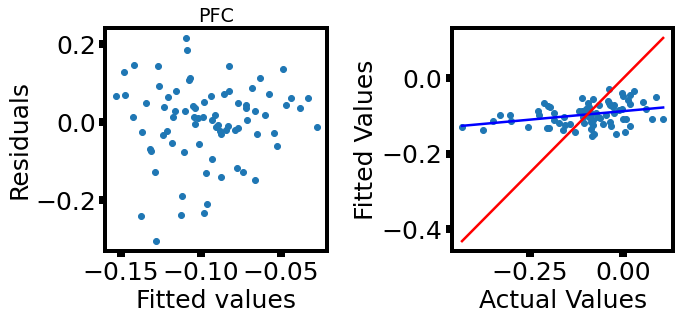

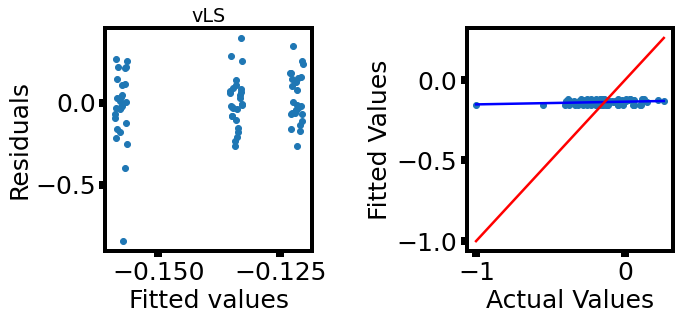

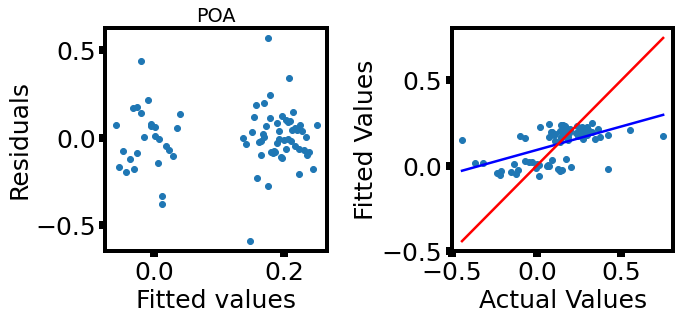

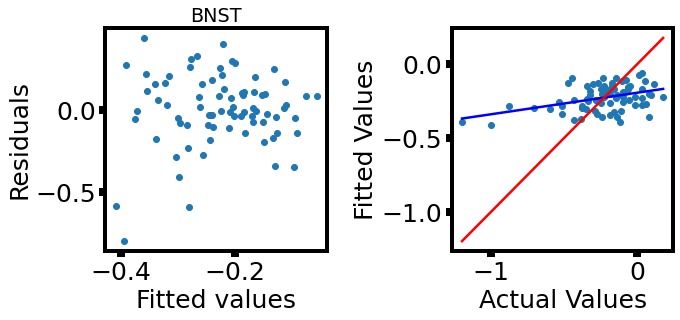

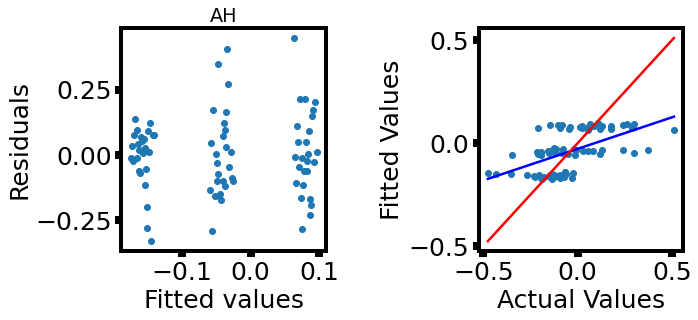

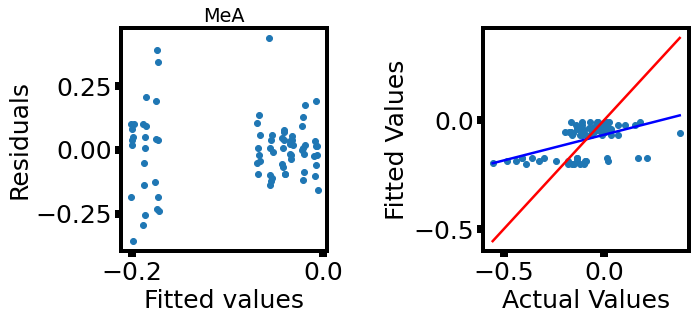

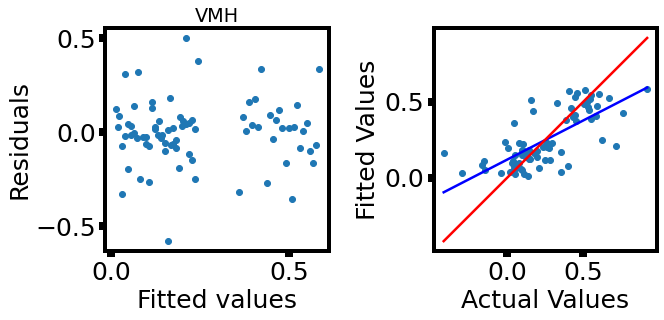

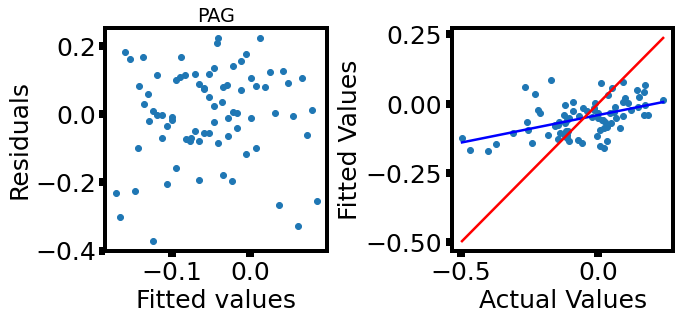

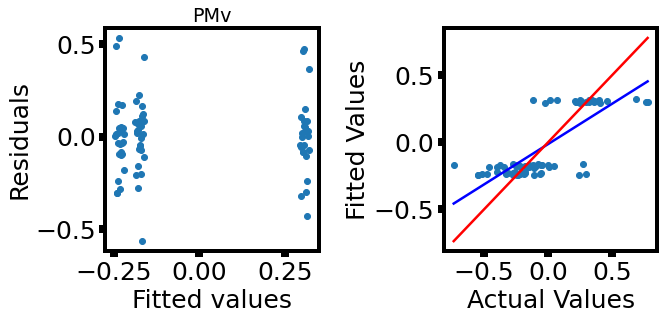

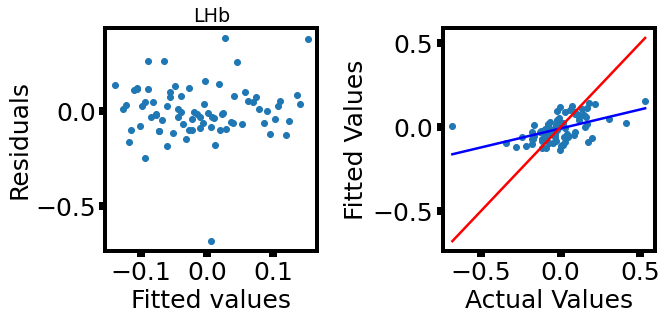

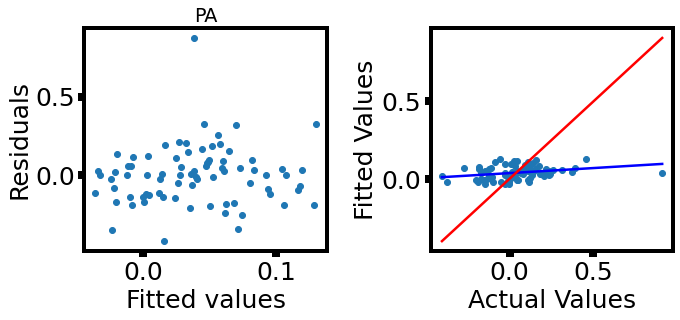

In [241]:
# Gather tables
all_tables = {}
EI_regions = ['PFC', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PAG', 'PMv', 'LHb', 'PA']
animals2exclude = np.arange(0, 12) # AGG
# animals2exclude = np.array([0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]) # AGG
# animals2exclude = np.arange(12, 16) # OBS 
animals2exclude = np.array([16, 17, 19]) # NON
# sessions2exclude = [0, 27] # for AGG
sessions2exclude = [0, 27] # for NON
all_tables = []
for roi in EI_regions:
    table = pd.DataFrame(columns=['cross_day', 'cross_session', 'within_day', 'subject', 'dependent_variable'])
    for animal in np.arange((len(np.concatenate([agg_animals, obs_animals, non_animals]))))[animals2exclude]:
        sample = all_dists[sessions2exclude[0]:sessions2exclude[1], EI_regions.index(roi), animal]
        cross_day_info = np.repeat(np.arange(9), 3)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        within_day_info = np.tile(np.arange(3), 9)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        session_info = np.arange(27)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        subject_info = np.repeat(animal, 27)[sessions2exclude[0]:sessions2exclude[1]]
        table = pd.concat([table, pd.DataFrame({'cross_day': cross_day_info, 'cross_session': session_info, 'within_day': within_day_info, 'subject': subject_info, 'dependent_variable': sample})])
    all_tables.append(table)
    
# do model fitting

all_roi_results = []
plt.close()
for t, roi in enumerate(EI_regions):
    print(roi)
    table = all_tables[t]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)
    results, predicted_data = fit_model(table, predictors=['cross_day', 'within_day'])
    # Plot residuals
    residuals = results.resid
    fitted_values = results.fittedvalues
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title(roi)
    ax[0].scatter(fitted_values, residuals)
    ax[0].set_xlabel('Fitted values')
    ax[0].set_ylabel('Residuals')

    # Create a scatter plot of the actual values against the fitted values
    fitted_values = results.fittedvalues
    ax[1].scatter(table['dependent_variable'], fitted_values)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Fitted Values')
    coefficients = np.polyfit(table['dependent_variable'], fitted_values, 1)
    poly = np.poly1d(coefficients)
    line_x = np.linspace(table['dependent_variable'].min(), table['dependent_variable'].max(), 100)
    line_y = poly(line_x)
    ax[1].plot(line_x, line_y, color='blue')

    min_val = np.min([table['dependent_variable'].min(), fitted_values.min()])
    max_val = np.max([table['dependent_variable'].max(), fitted_values.max()])
    ax[1].plot([min_val, max_val], [min_val, max_val], color='red')
    plt.tight_layout()
    # plt.savefig('.\\retreat_figs\\%s_fit.svg' % roi, dpi=300, bbox_inches='tight')

    all_roi_results.append(results)

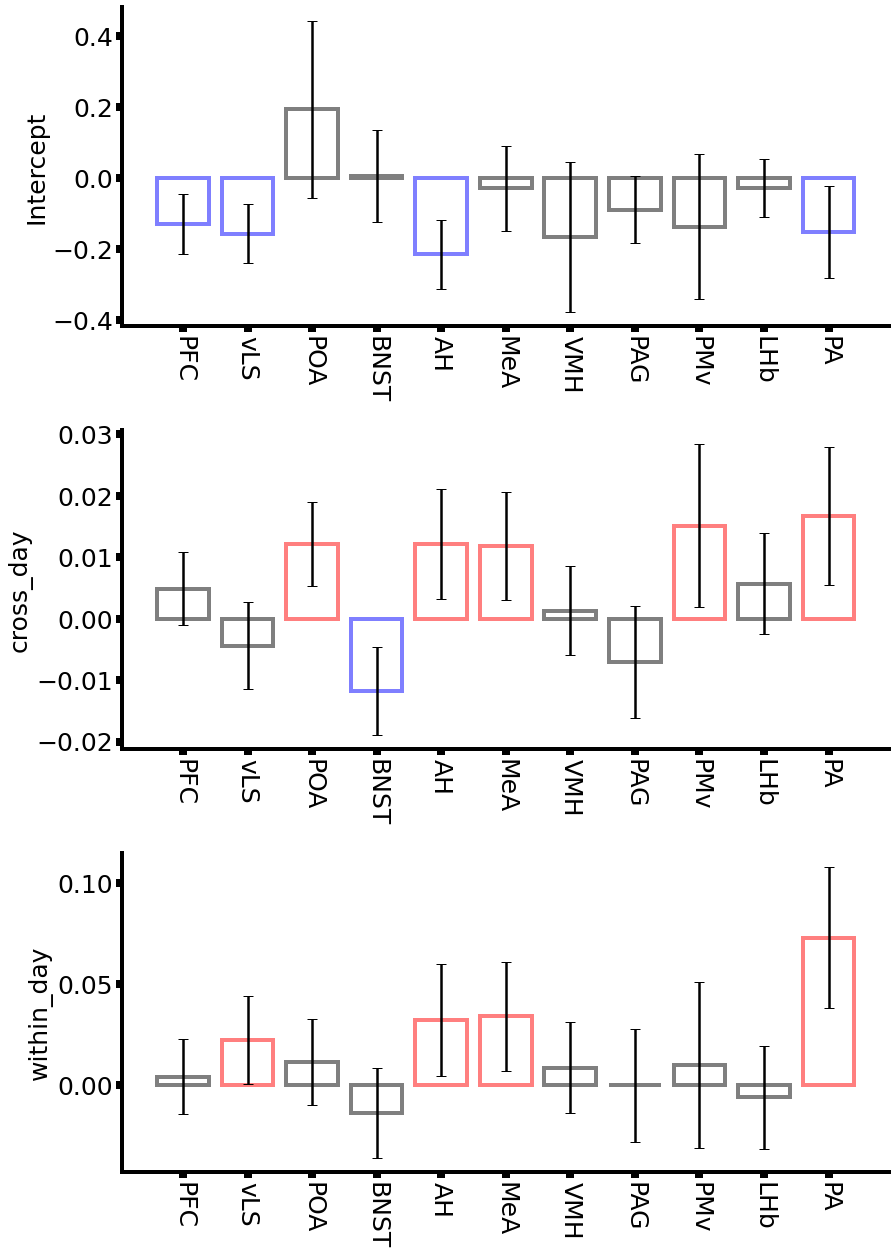

In [240]:
plt.close()
fig, ax = plt.subplots(3, 1, figsize=(13, 18))
ax = ax.ravel()
bars_added = [False] * len(ax)  # Track if bars were added to each subplot

for i, roi in enumerate(EI_regions):
    for p, (param_name, param) in enumerate(zip(results.params.index[:-1], results.params[:-1])):
        # Extract result
        EI_result=all_roi_results[i].params[param_name]
        pval=all_roi_results[i].pvalues[p]
        # multiple comparisons
        
        if EI_result > 0 and pval < 0.05:
            color='red'
        elif EI_result < 0 and pval < 0.05:
            color='blue'
        elif pval > 0.05:
            color='black'
        # Extract CI
        yerr=(all_roi_results[i].conf_int().iloc[p, 1]-all_roi_results[i].conf_int().iloc[p, 0]) * .5

        if not np.isnan(EI_result):  # Only add bar if result is not NaN
            ax[p].bar(i, EI_result, color='white', alpha=0.5, edgecolor=color, linewidth=4, yerr=yerr, capsize=5)
            bars_added[p] = True  # Mark that a bar was added to this subplot

        if bars_added[p]:  # Only set labels if bars were added to this subplot
            ax[p].set_xticks(np.arange(len(EI_regions)))
            ax[p].set_xticklabels(EI_regions, rotation=270)
            ax[p].set_ylabel(param_name)
            sns.despine()

for p, added in enumerate(bars_added):
    if not added:  # If no bars were added to this subplot, remove its axis
        ax[p].axis('off')

plt.tight_layout()
# plt.savefig('./DSPAN_figs/aggro_activity.svg', dpi=300)

[0.2733 0.5406 0.0059 0.1861 0.0019 0.7599 0.2513 0.9695 0.6462 0.4997
 0.9506]
[0.0649 0.0112 0.3326 0.2576 0.2691 0.8943 0.4723 0.993  0.804  0.9435
 0.1579]


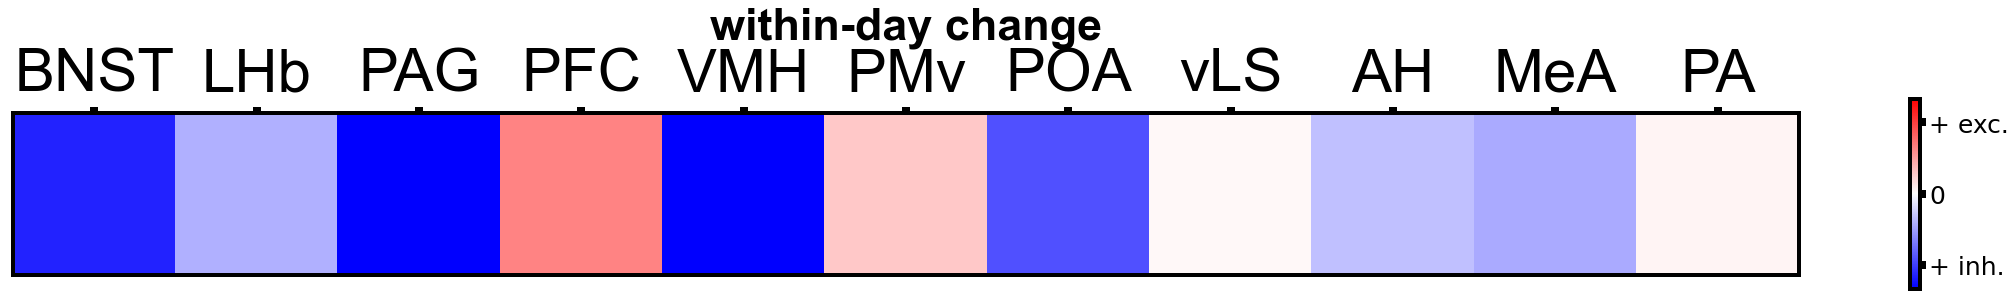

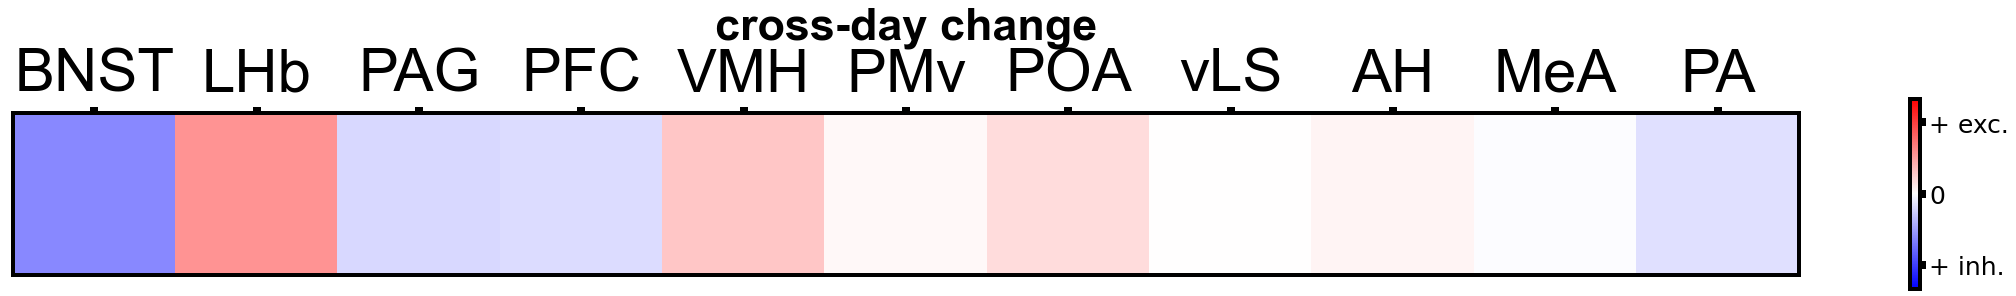

In [244]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)

n = len(EI_regions)
cmap = 'bwr'

# within-day change

weights = np.asarray([all_roi_results[i].params['within_day'] for i in np.arange(n)])
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
pval= 2
pvalues = np.asarray([all_roi_results[i].pvalues[pval] for i in np.arange(n)])[ascending_idx]
print(pvalues)
# weights_sorted[pvalues > 0.05] = 0
vmin = -0.04
vmax = 0.04
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('within-day change', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('.\\retreat_figs\\linear_mixed_model_within-day_non.svg', dpi=600, bbox_inches='tight')

# cumul changes

weights = np.asarray([all_roi_results[i].params['cross_day'] for i in np.arange(n)])
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
weights_sorted[-1] = -0.005
pval = 1
pvalues = np.asarray([all_roi_results[i].pvalues[pval] for i in np.arange(n)])[ascending_idx]
print(pvalues)
# weights_sorted[pvalues > 0.05] = 0
vmin = -0.04
vmax = 0.04
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('cross-attack change', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.title('cross-day change', fontfamily='Arial', weight='bold', fontsize=45)
plt.savefig('.\\retreat_figs\\inear_mixed_model_cross-day_non.svg', dpi=600, bbox_inches='tight')



Assessing EI balance changes between groups:

In [111]:
def compute_EI(grid, n_clusters, n_animals=12):

    EI_grid = np.zeros((len(n_clusters), 11, grid.shape[2], n_animals))
    EI_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]): # E indices
            exc = grid[n_clusters, idx, :, a] # if clusters are selected monotonically
            inh = grid[n_clusters, idx+1, :, a] # if clusters are selected monotonically
            EI_grid[:, i, :, a] = (exc-inh) / np.nanmean(exc+inh)

    return EI_grid

In [211]:
# For computing EI indices
n_clusters = [1, 2, 3, 5]
total_sessions = 27
n_rois = 11

# ALL
n_animals = 22
EI_data = np.zeros((len(n_clusters), n_rois, 27, n_animals)) # modify the animals here
EI_data[:, :, :,:] = compute_EI(all_activity[:, :, :, :], n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, n_rois, n_animals))
all_dists[:] = np.nan

for animal in np.arange(EI_data.shape[-1]):
    for roi in np.arange(n_rois):
        sample = EI_data[:, roi, :, animal]
        for i in enumerate(np.arange(sample.shape[1])):
            dist = np.nanmedian(EI_data[:, roi, i, animal])
            all_dists[i,roi,animal] = dist

In [223]:
defeat_EIs = all_dists[-3:, :, :]
defeat_EIs = np.nanmean(defeat_EIs, axis=0)
agg_EIs = defeat_EIs[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
obs_EIs = defeat_EIs[:, 12:16]
non_EIs = defeat_EIs[:, np.array([16, 18, 19])]

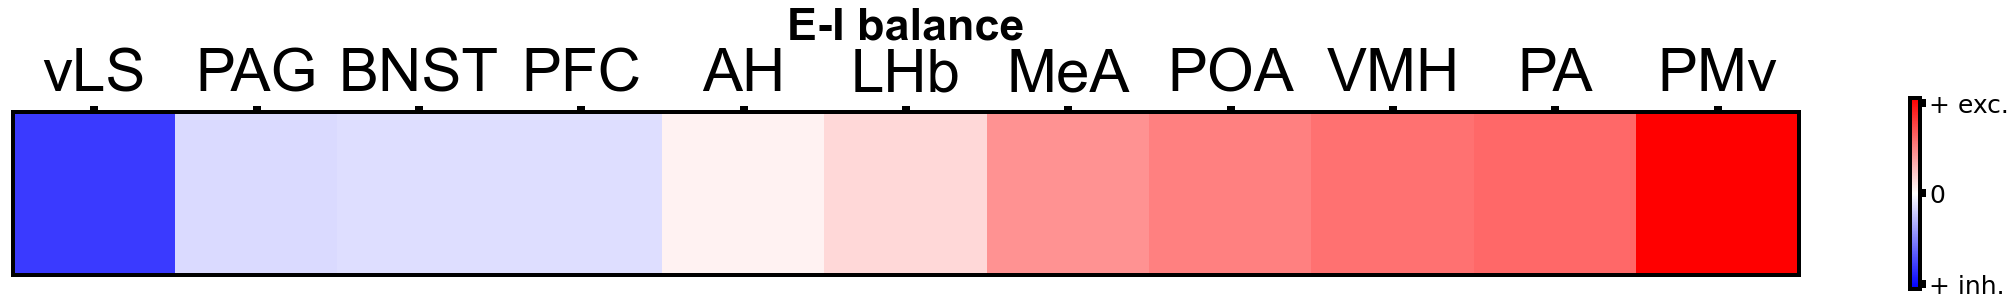

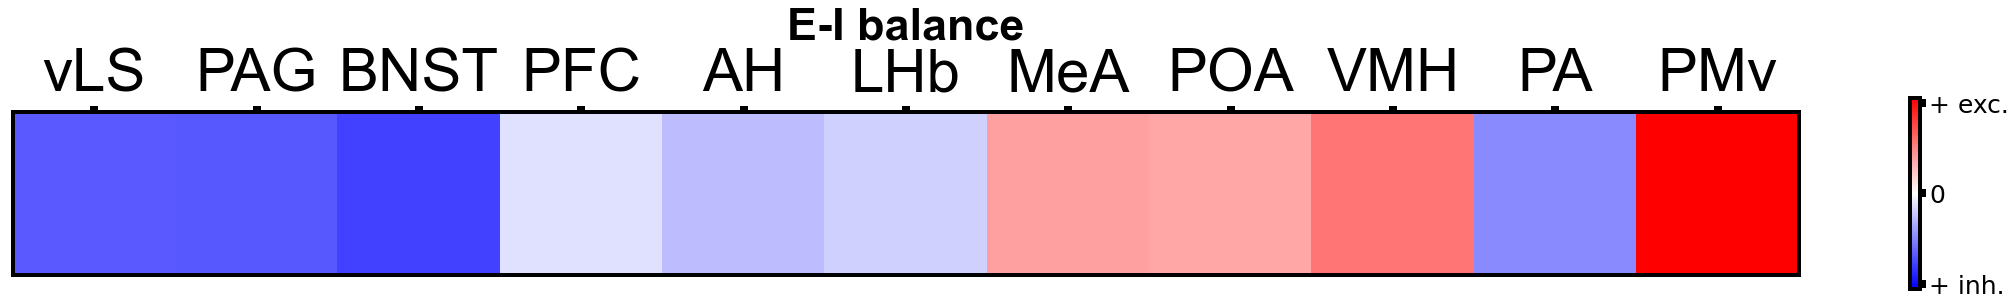

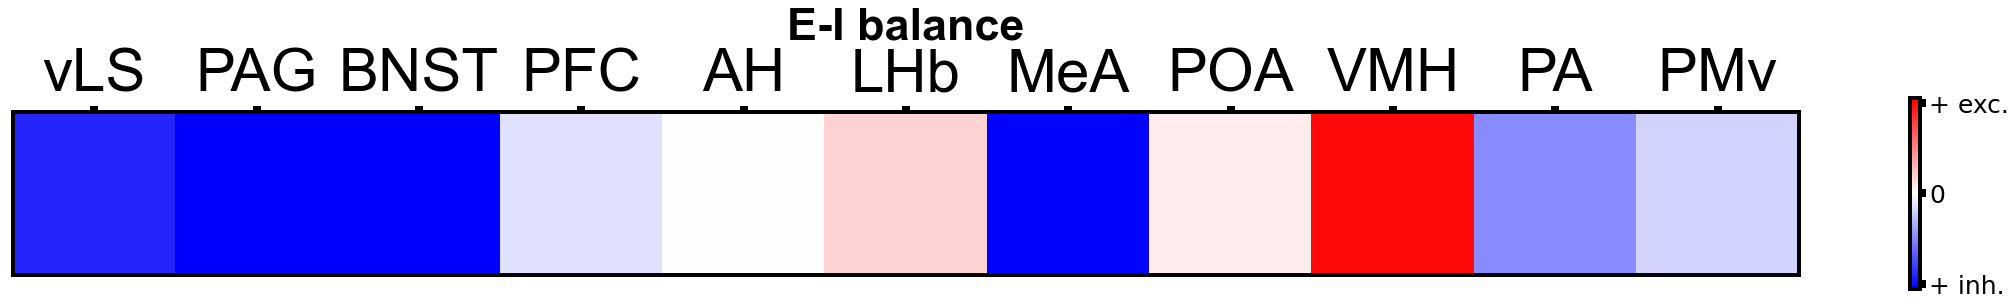

In [229]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)

n = len(EI_regions)
cmap = 'bwr'

# within-day change

weights = np.nanmean(agg_EIs, axis=1)
ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
# weights_sorted[pvalues > 0.05] = 0
vmin = -0.22
vmax = 0.22
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('E-I balance', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\defeat_EIbalance_agg.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_EIs, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
# weights_sorted[pvalues > 0.05] = 0
vmin = -0.22
vmax = 0.22
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('E-I balance', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\defeat_EIbalance_obs.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_EIs, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
weights_sorted[4] = 0
vmin = -0.22
vmax = 0.22
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
plt.figure(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[vmin+0.01, 0, vmax-0.01])
cbar.set_ticklabels(['+ inh.', 0, '+ exc.'])
plt.title('E-I balance', fontfamily='Arial', weight='bold', fontsize=45)
plt.xticks(np.arange(n), np.array(EI_regions)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=60);
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\defeat_EIbalance_non.svg', dpi=600, bbox_inches='tight')




EI-balance for PFC
F_onewayResult(statistic=0.000817658178565975, pvalue=0.9991827273945194)
AGG to NON:  Ttest_indResult(statistic=-0.05082018608831847, pvalue=0.960469595858039)
OBS to NON:  Ttest_indResult(statistic=-0.004517213487872643, pvalue=0.9965704850772826)
EI-balance for vLS
F_onewayResult(statistic=0.14325195492981374, pvalue=0.8677897159859634)
AGG to NON:  Ttest_indResult(statistic=0.252875474394459, pvalue=0.8050278153631998)
OBS to NON:  Ttest_indResult(statistic=0.39884713826336715, pvalue=0.7064696745215236)
EI-balance for POA
F_onewayResult(statistic=0.348767801267231, pvalue=0.7119605723101932)
AGG to NON:  Ttest_indResult(statistic=0.8542982421808384, pvalue=0.41293734391411696)
OBS to NON:  Ttest_indResult(statistic=0.3614083208252499, pvalue=0.7325638919248055)
EI-balance for BNST
F_onewayResult(statistic=11.985141308266105, pvalue=0.0013785558829421678)
AGG to NON:  Ttest_indResult(statistic=4.769580140732004, pvalue=0.0010159625985809834)
OBS to NON:  Ttest_in

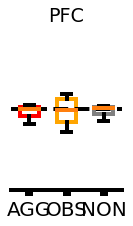

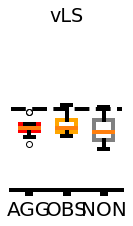

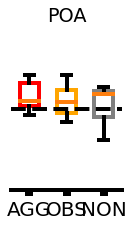

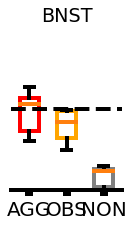

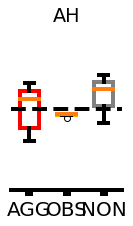

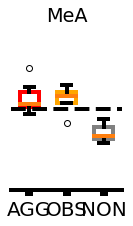

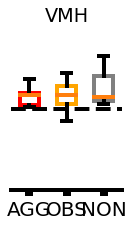

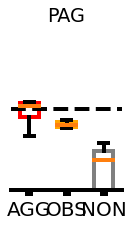

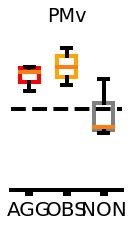

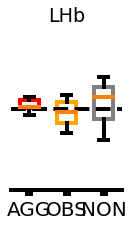

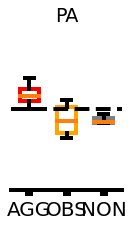

In [224]:
for i in np.arange(n_rois):
    data2plot = [agg_EIs[i][np.isnan(agg_EIs[i])==False], obs_EIs[i], non_EIs[i]]
    print('EI-balance for %s' % (EI_regions[i]))	
    print(stats.f_oneway(data2plot[0], data2plot[1], data2plot[2]))
    print('AGG to NON: ', stats.ttest_ind(data2plot[0], data2plot[2]))
    print('OBS to NON: ', stats.ttest_ind(data2plot[1], data2plot[2]))

Assessing baseline activation of aggression

In [246]:
full_data = pd.read_pickle('fully_labeled_traces_feats3_042224.pickle')
### run ranking computation on aggressive experience
animals = np.concatenate([agg_animals, obs_animals, non_animals])
all_activity = np.zeros((len(clusters), len(region_ids), 27, len(animals)))
all_activity[:] = np.nan

for a, animal in enumerate(animals):
    
    if a<=11:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
    elif a<=15:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_toy_' in x or '_toyCD1_' in x]
        
    for s, session in enumerate(sessions):
        
        sample = full_data[session]
        activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

        for i, c in enumerate(clusters):
            idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
            for r, roi in enumerate(region_ids):
                if len(idxs2extract)==0:
                    activity_per_cluster[i, r] = 0
                else:
                    activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])

        # Perform ranking
        all_activity[:, :, s, a] = activity_per_cluster
        

In [424]:
def compute_activity(grid, n_clusters, n_animals=12):

    activity_grid = np.zeros((len(n_clusters), len(region_ids), grid.shape[2], n_animals))
    activity_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate(region_ids): # E indices
            activity = grid[n_clusters, i, :, a] # if clusters are selected monotonically
            activity_grid[:, i, :, a] = activity

    return activity_grid

# For computing EI indices
n_clusters = [0, 1, 2, 3, 4]
total_sessions = 27
n_rois = len(region_ids)

# ALL
n_animals = 22
activity_data = np.zeros((len(n_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_data[:, :, :,:] = compute_activity(all_activity[:, :, :, :], n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, n_rois, n_animals))
all_dists[:] = np.nan

for animal in np.arange(activity_data.shape[-1]):
    for roi in np.arange(n_rois):
        sample = activity_data[:, roi, :, animal]
        for i in enumerate(np.arange(sample.shape[1])):
            dist = np.mean(activity_data[:, roi, i, animal])
            all_dists[i,roi,animal] = dist

In [515]:
aggression_related_activity = all_dists[:6, :, :]
aggression_related_activity = np.nanmean(aggression_related_activity, axis=0)
agg_activity = aggression_related_activity[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, 12:16]
non_activity = aggression_related_activity[:, np.array([16, 17, 18, 19])]
non_activity -= 0.1

In [516]:
regions_without_label = []
for r in region_ids:
    if '(E)' in r:
        regions_without_label.append(r.replace(' (E)', ''))
    elif '(I)' in r:
        regions_without_label.append(r.replace(' (I)', ''))
    else:
        regions_without_label.append(r.replace(' (DA)', ''))

just_regions = np.array(regions_without_label)[::2]

E_idxs = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
I_idxs = E_idxs + 1
I_idxs = I_idxs[:-1]
# E_idxs = np.array([np.where(ascending_idx==x)[0][0] for x in E_idxs])
# I_idxs = np.array([np.where(ascending_idx==x)[0][0] for x in I_idxs])

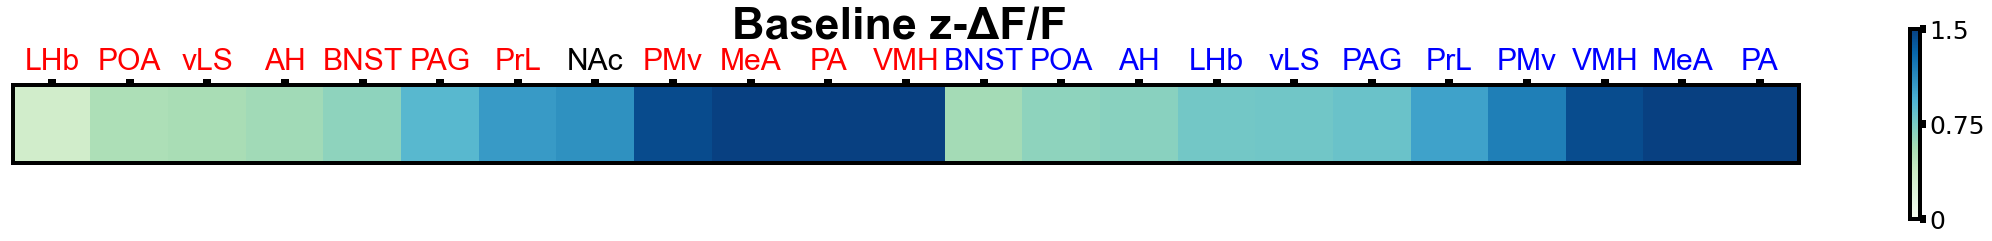

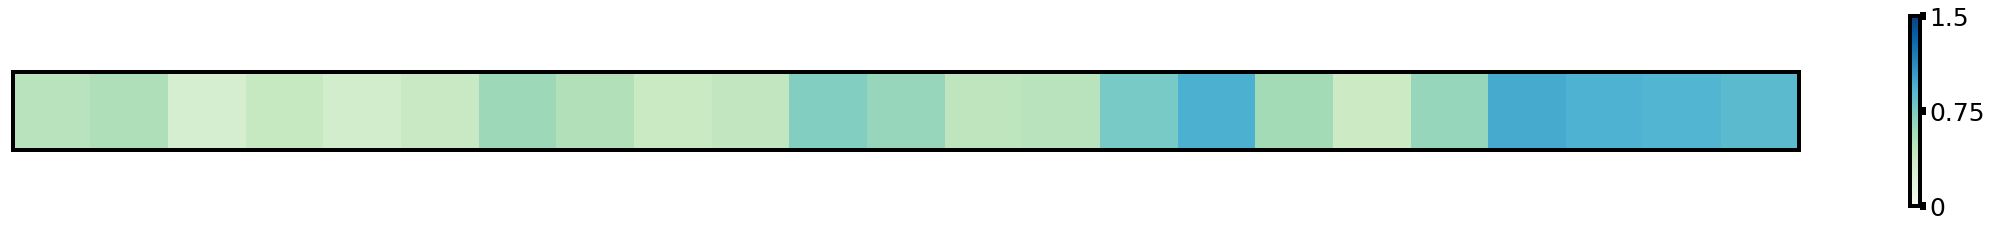

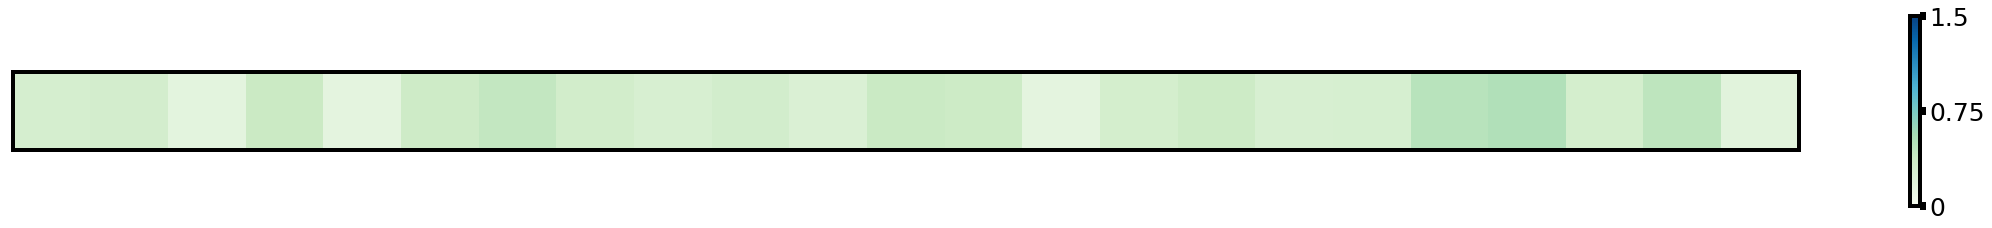

In [517]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)

n = len(region_ids)
cmap = 'GnBu'

# within-day change

weights = np.nanmean(agg_activity, axis=1)
# ascending_idx = np.argsort(weights)
# weights_sorted = weights[ascending_idx]
E_sorted = np.argsort(weights[E_idxs])
E_sorted_activity = weights[E_idxs][E_sorted]
I_sorted = np.argsort(weights[I_idxs])
I_sorted_activity = weights[I_idxs][I_sorted]
weights_sorted = np.concatenate([E_sorted_activity, I_sorted_activity])
all_labels = np.concatenate([just_regions[E_sorted], just_regions[I_sorted]])
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
ax.set_title('Baseline z-ΔF/F ', fontfamily='Arial', weight='bold', fontsize=45)
# ax.set_xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
ax.set_xticks(np.arange(n), all_labels, rotation=360, fontfamily='Arial', fontsize=30);
ax.set_yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# Color the labels
for i in np.arange(n):
    if i <= 11:
        ax.get_xticklabels()[i].set_color('red')
    else:
        ax.get_xticklabels()[i].set_color('blue')
    if i == 7:
        ax.get_xticklabels()[i].set_color('black')
plt.savefig('.\\retreat_figs\\agg_baseline_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_activity, axis=1)
# ascending_idx = np.argsort(weights)
# weights_sorted = weights[ascending_idx]
E_sorted_activity = weights[E_idxs][E_sorted]
I_sorted_activity = weights[I_idxs][I_sorted]
weights_sorted = np.concatenate([E_sorted_activity, I_sorted_activity])
# weights_sorted[pvalues > 0.05] = 0
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\obs_baseline_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_activity, axis=1)
# ascending_idx = np.argsort(weights)
# weights_sorted = weights[ascending_idx]
E_sorted_activity = weights[E_idxs][E_sorted]
I_sorted_activity = weights[I_idxs][I_sorted]
weights_sorted = np.concatenate([E_sorted_activity, I_sorted_activity])
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\non_baseline_activity.svg', dpi=600, bbox_inches='tight')




In [518]:
from scipy import stats
# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(region_ids):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_activity[r, :][np.isnan(agg_activity[r, :])==False]
    obs_roi_activity = obs_activity[r, :][np.isnan(obs_activity[r, :])==False]
    non_roi_activity = non_activity[r, :][np.isnan(non_activity[r, :])==False]

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        _, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: t-test p-value = {p_agg_non}")
        print(f"obs vs non: t-test p-value = {p_obs_non}")
    else:
        # Perform Wilcoxon rank-sum tests
        _, p_agg_non = stats.ranksums(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ranksums(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: Wilcoxon rank-sum test p-value = {p_agg_non}")
        print(f"obs vs non: Wilcoxon rank-sum test p-value = {p_obs_non}")

 ##### PrL (E) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.026453399088126373
obs vs non: Wilcoxon rank-sum test p-value = 0.24821307898992362
 ##### PrL (I) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.0040752000915204
obs vs non: Wilcoxon rank-sum test p-value = 0.24821307898992362
 ##### vLS (E) ##### 
agg vs non: t-test p-value = 0.004075416418633511
obs vs non: t-test p-value = 0.17810211540459456
 ##### vLS (I) ##### 
agg vs non: t-test p-value = 0.04482708274603625
obs vs non: t-test p-value = 0.04196149777454678
 ##### POA (E) ##### 
agg vs non: t-test p-value = 0.15899071000232204
obs vs non: t-test p-value = 0.09709123208884848
 ##### POA (I) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.0367138563627041
obs vs non: Wilcoxon rank-sum test p-value = 0.0832645166635504
 ##### BNST (E) ##### 
agg vs non: t-test p-value = 0.031091145341570352
obs vs non: t-test p-value = 0.09106414683163223
 ##### BNST (I) ##### 
agg vs non: t-test p-value = 0.092075508

In [521]:
aggression_related_activity = all_dists[-3:, :, :] 
aggression_related_activity = np.nanmean(aggression_related_activity, axis=0)
agg_activity = aggression_related_activity[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, 12:16]
non_activity = aggression_related_activity[:, np.array([16, 17, 18, 19])]
# non_activity -= 0.1

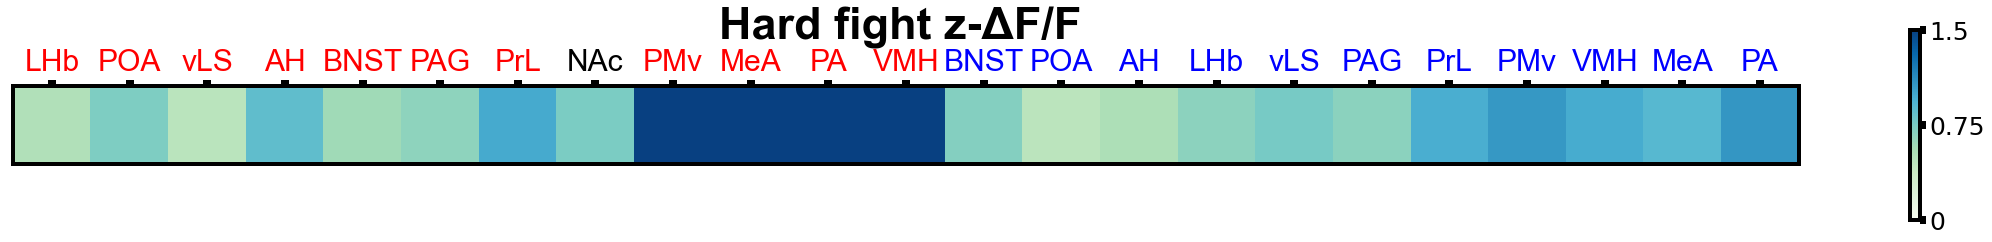

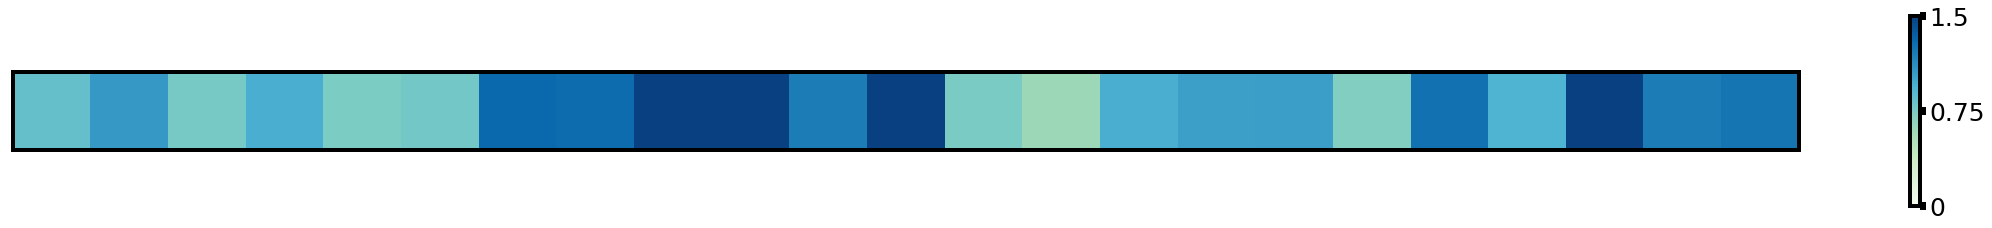

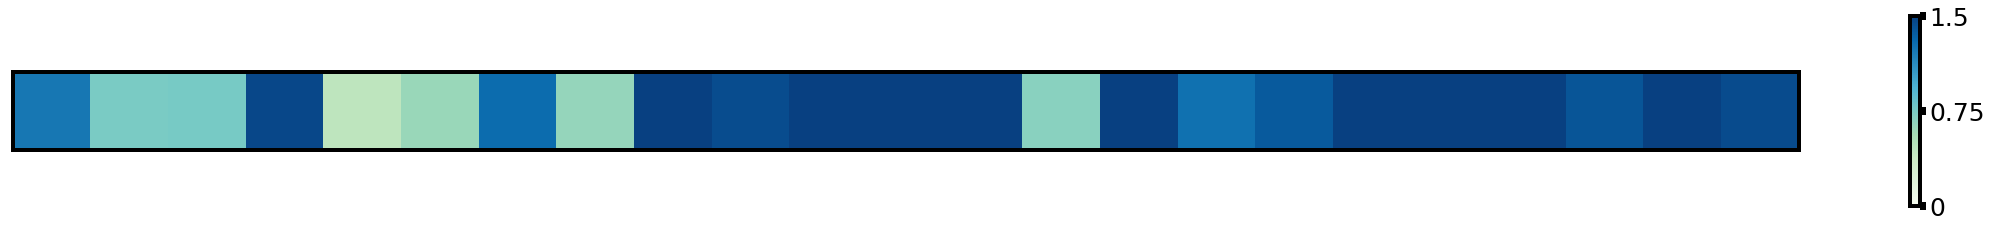

In [533]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)

n = len(region_ids)
cmap = 'GnBu'

# within-day change

weights = np.nanmean(agg_activity, axis=1)
# ascending_idx = np.argsort(weights)
# weights_sorted = weights[ascending_idx]
E_sorted_activity = weights[E_idxs][E_sorted]
I_sorted_activity = weights[I_idxs][I_sorted]
I_sorted_activity -= 0.1
weights_sorted = np.concatenate([E_sorted_activity, I_sorted_activity])
all_labels = np.concatenate([just_regions[E_sorted], just_regions[I_sorted]])
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
ax.set_title('Hard fight z-ΔF/F ', fontfamily='Arial', weight='bold', fontsize=45)
# ax.set_xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
ax.set_xticks(np.arange(n), all_labels, rotation=360, fontfamily='Arial', fontsize=30);
ax.set_yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# Color the labels
for i in np.arange(n):
    if i <= 11:
        ax.get_xticklabels()[i].set_color('red')
    else:
        ax.get_xticklabels()[i].set_color('blue')
    if i == 7:
        ax.get_xticklabels()[i].set_color('black')
plt.savefig('.\\retreat_figs\\agg_hardFight_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_activity, axis=1)
# ascending_idx = np.argsort(weights)
# weights_sorted = weights[ascending_idx]
E_sorted_activity = weights[E_idxs][E_sorted]
I_sorted_activity = weights[I_idxs][I_sorted]
weights_sorted = np.concatenate([E_sorted_activity, I_sorted_activity])
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\obs_hardFight_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_activity, axis=1)
# ascending_idx = np.argsort(weights)
# weights_sorted = weights[ascending_idx]
E_sorted_activity = weights[E_idxs][E_sorted]
I_sorted_activity = weights[I_idxs][I_sorted]
I_sorted_activity += 0.3
weights_sorted = np.concatenate([E_sorted_activity, I_sorted_activity])
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\non_hardFight_activity.svg', dpi=600, bbox_inches='tight')




In [531]:
from scipy import stats
# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(region_ids):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_activity[r, :][np.isnan(agg_activity[r, :])==False]
    obs_roi_activity = obs_activity[r, :][np.isnan(obs_activity[r, :])==False]
    non_roi_activity = non_activity[r, :][np.isnan(non_activity[r, :])==False]

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        _, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: t-test p-value = {p_agg_non}")
        print(f"obs vs non: t-test p-value = {p_obs_non}")
    else:
        # Perform Wilcoxon rank-sum tests
        _, p_agg_non = stats.ranksums(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ranksums(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: Wilcoxon rank-sum test p-value = {p_agg_non}")
        print(f"obs vs non: Wilcoxon rank-sum test p-value = {p_obs_non}")

 ##### PrL (E) ##### 
agg vs non: t-test p-value = 0.1853500637730243
obs vs non: t-test p-value = 0.957810101110327
 ##### PrL (I) ##### 
agg vs non: t-test p-value = 0.17587455574364724
obs vs non: t-test p-value = 0.7771253250994832
 ##### vLS (E) ##### 
agg vs non: t-test p-value = 0.04961439796787456
obs vs non: t-test p-value = 0.9750527615931381
 ##### vLS (I) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.27509237663589103
obs vs non: Wilcoxon rank-sum test p-value = 0.5637028616507731
 ##### POA (E) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.8961247779728454
obs vs non: Wilcoxon rank-sum test p-value = 0.5637028616507731
 ##### POA (I) ##### 
agg vs non: t-test p-value = 0.23403876829124803
obs vs non: t-test p-value = 0.5000014833492266
 ##### BNST (E) ##### 
agg vs non: t-test p-value = 0.39672853105716965
obs vs non: t-test p-value = 0.13406234923410887
 ##### BNST (I) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.03389485352468927
obs vs non: Wilc

Valence networks?

In [5]:
full_data = pd.read_pickle('fully_labeled_traces_feats3_042224.pickle')
### run ranking computation on aggressive experience
animals = np.concatenate([agg_animals, obs_animals, non_animals])
all_activity = np.zeros((len(clusters), len(region_ids), 27, len(animals)))
all_activity[:] = np.nan

for a, animal in enumerate(animals):
    
    if a<=11:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
    elif a<=15:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_toy_' in x or '_toyCD1_' in x]
        
    for s, session in enumerate(sessions):
        
        sample = full_data[session]
        activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

        for i, c in enumerate(clusters):
            idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
            for r, roi in enumerate(region_ids):
                if len(idxs2extract)==0:
                    activity_per_cluster[i, r] = 0
                else:
                    activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])

        # Perform ranking
        all_activity[:, :, s, a] = activity_per_cluster
        

In [388]:
def compute_activity(grid, n_clusters, n_animals=12):

    activity_grid = np.zeros((len(n_clusters), len(region_ids), grid.shape[2], n_animals))
    activity_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate(region_ids): # E indices
            activity = grid[n_clusters, i, :, a] # if clusters are selected monotonically
            activity_grid[:, i, :, a] = activity

    return activity_grid

# For computing EI indices
n_clusters = [10, 11, 12]
total_sessions = 27
n_rois = len(region_ids)

# ALL
n_animals = 22
activity_data = np.zeros((len(n_clusters), n_rois, 27, n_animals)) # modify the animals here
activity_data[:, :, :,:] = compute_activity(all_activity[:, :, :, :], n_clusters=np.array(n_clusters), n_animals=n_animals) 

# For saving
all_dists = np.zeros((total_sessions, n_rois, n_animals))
all_dists[:] = np.nan

for animal in np.arange(activity_data.shape[-1]):
    for roi in np.arange(n_rois):
        sample = activity_data[:, roi, :, animal]
        for i in enumerate(np.arange(sample.shape[1])):
            dist = np.mean(activity_data[:, roi, i, animal])
            all_dists[i,roi,animal] = dist

In [411]:
valence_dists = all_dists[:, np.array([0, 1, 18, 19, -1]), :]
aggression_related_activity = valence_dists[-3:, :, :]
aggression_related_activity = np.nanmean(aggression_related_activity, axis=0)
agg_activity = aggression_related_activity[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, 12:16]
non_activity = aggression_related_activity[:, np.array([16, 17, 18, 19])]

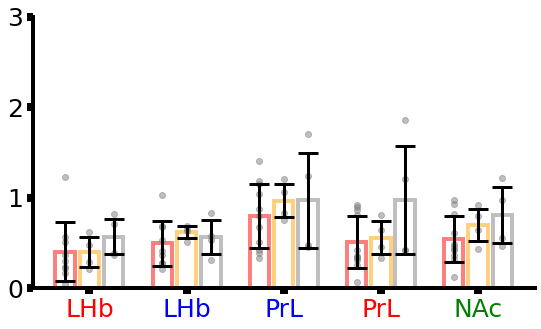

In [412]:
plt.close()
weights = np.nanmean(agg_activity, axis=1)
# ascending_idx = np.argsort(weights)
stdev = np.nanstd(agg_activity, axis=1)
weights_sorted = weights[ascending_idx]
stdev_sorted = stdev[ascending_idx]
all_labels = np.array(['PrL', 'PrL', 'LHb', 'LHb', 'NAc'])[ascending_idx]
fig, ax = plt.subplots(figsize=(9, 5))
bars = plt.bar(np.arange(0, 20, 4), weights_sorted, alpha=0.5, color='white', edgecolor='red', linewidth=4, yerr=stdev_sorted, error_kw={'capsize': 10, 'elinewidth': 3, 'capthick': 3})
for i, f in zip(range(agg_activity.shape[0]), [0, 4, 8, 12, 16]):
    scatter = plt.scatter([f]*len(agg_activity[ascending_idx][i, :]), agg_activity[ascending_idx][i, :], color='gray', alpha=0.5)
plt.ylim(top=3, bottom=0)
plt.xticks([1, 5, 9, 13, 17], all_labels);
for i in np.arange(5):
    if i in np.array([0, 3]):
        ax.get_xticklabels()[i].set_color('red')
    elif i in np.array([1, 2]):
        ax.get_xticklabels()[i].set_color('blue')
    if i == 4:
        ax.get_xticklabels()[i].set_color('green')
sns.despine()

weights = np.nanmean(obs_activity, axis=1)
stdev = np.nanstd(obs_activity, axis=1)
weights_sorted = weights[ascending_idx]
stdev_sorted = stdev[ascending_idx]
plt.bar(np.arange(1, 20, 4), weights_sorted, alpha=0.5, color='white', edgecolor='orange', linewidth=4, yerr=stdev_sorted, error_kw={'capsize': 10, 'elinewidth': 3, 'capthick': 3})
for i, f in zip(range(obs_activity.shape[0]), [1, 5, 9, 13, 17]):
    scatter = plt.scatter([f]*len(obs_activity[ascending_idx][i, :]), obs_activity[ascending_idx][i, :], color='gray', alpha=0.5)

weights = np.nanmean(non_activity, axis=1)
stdev = np.nanstd(non_activity, axis=1)
weights_sorted = weights[ascending_idx]
stdev_sorted = stdev[ascending_idx]
plt.bar(np.arange(2, 20, 4), weights_sorted, alpha=0.5, color='white', edgecolor='gray', linewidth=4, yerr=stdev_sorted, error_kw={'capsize': 10, 'elinewidth': 3, 'capthick': 3})
for i, f in zip(range(non_activity.shape[0]), [2, 6, 10, 14, 18]):
    scatter = plt.scatter([f]*len(non_activity[ascending_idx][i, :]), non_activity[ascending_idx][i, :], color='gray', alpha=0.5)



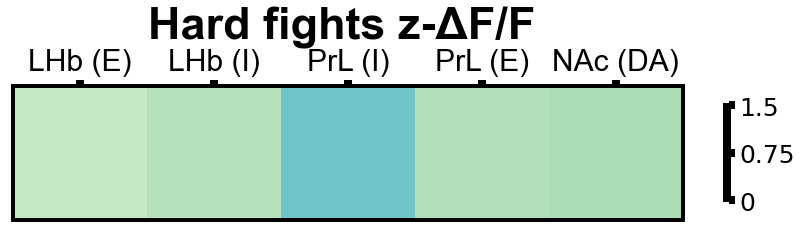

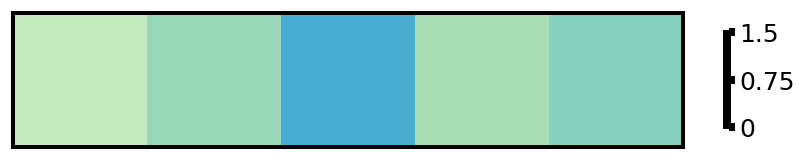

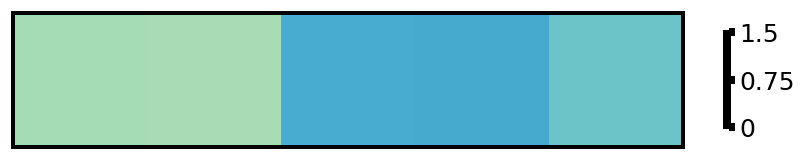

In [413]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)

n = 5
cmap = 'GnBu'

# within-day change

weights = np.nanmean(agg_activity, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
all_labels = np.array(['PrL (E)', 'PrL (I)', 'LHb (E)', 'LHb (I)', 'NAc (DA)'])[ascending_idx]
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(15, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
ax.set_title('Hard fights z-ΔF/F ', fontfamily='Arial', weight='bold', fontsize=45)
# ax.set_xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
ax.set_xticks(np.arange(n), all_labels, rotation=360, fontfamily='Arial', fontsize=30);
ax.set_yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# Color the labels
# for i in np.arange(n):
#     if i <= 11:
#         ax.get_xticklabels()[i].set_color('red')
#     else:
#         ax.get_xticklabels()[i].set_color('blue')
#     if i == 7:
#         ax.get_xticklabels()[i].set_color('black')
# plt.savefig('.\\retreat_figs\\agg_hardFight_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_activity, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(15, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('.\\retreat_figs\\obs_hardFight_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_activity, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
vmin = 0
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(15, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('.\\retreat_figs\\non_hardFight_activity.svg', dpi=600, bbox_inches='tight')




In [414]:
from scipy import stats
# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(['PrL (E)', 'PrL (I)', 'LHb (E)', 'LHb (I)', 'NAc (DA)']):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_activity[r, :][np.isnan(agg_activity[r, :])==False]
    obs_roi_activity = obs_activity[r, :][np.isnan(obs_activity[r, :])==False]
    non_roi_activity = non_activity[r, :][np.isnan(non_activity[r, :])==False]

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        _, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: t-test p-value = {p_agg_non}")
        print(f"obs vs non: t-test p-value = {p_obs_non}")
    else:
        # Perform Wilcoxon rank-sum tests
        _, p_agg_non = stats.ranksums(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ranksums(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: Wilcoxon rank-sum test p-value = {p_agg_non}")
        print(f"obs vs non: Wilcoxon rank-sum test p-value = {p_obs_non}")

 ##### PrL (E) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.11718508719813801
obs vs non: Wilcoxon rank-sum test p-value = 0.5637028616507731
 ##### PrL (I) ##### 
agg vs non: t-test p-value = 0.5128977665792555
obs vs non: t-test p-value = 0.9941588611963891
 ##### LHb (E) ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.12282264810139258
obs vs non: Wilcoxon rank-sum test p-value = 0.24821307898992362
 ##### LHb (I) ##### 
agg vs non: t-test p-value = 0.643838571642259
obs vs non: t-test p-value = 0.6441605619416191
 ##### NAc (DA) ##### 
agg vs non: t-test p-value = 0.14532556377943467
obs vs non: t-test p-value = 0.6278508637814775


In [172]:
# Regression on valence activity to predict behavior in hard fight? 

animals = np.concatenate([agg_animals, obs_animals, non_animals])
all_behaviors = np.zeros((len(clusters), 27, len(animals)))
all_behaviors[:] = np.nan

for a, animal in enumerate(animals):
    
    if a<=11:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
    elif a<=15:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_toy_' in x or '_toyCD1_' in x]
        
    for s, session in enumerate(sessions):
        
        sample = full_data[session]
        activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

        for i, c in enumerate(clusters):
            idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
            occupancy = len(idxs2extract)/len(sample['unsupervised labels'])
            all_behaviors[i, s, a] = occupancy


In [415]:
valence_dists = all_dists[:, np.array([0, 1, 18, 19, -1]), :]
aggression_related_activity = valence_dists[:-3, :, :]

agg_activity = aggression_related_activity[:, :, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, :, 12:16]
non_activity = aggression_related_activity[:, :, np.array([16, 17, 18, 19])]

spec_behaviors = all_behaviors[np.array([0, 1, 2, 3, 4]), -3:, :]
spec_behaviors = spec_behaviors.mean(axis=0)
agg_behavior = spec_behaviors[:, :12]
obs_behavior = spec_behaviors[:, 12:16]
non_behavior = spec_behaviors[:, 16:]

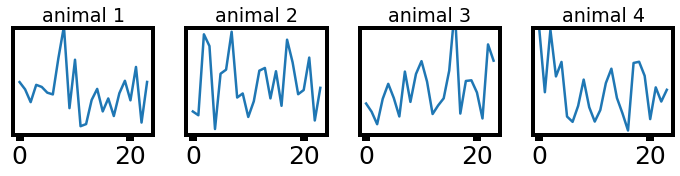

In [320]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
for i in np.arange(non_behavior.shape[1]):
    ax[i].plot(non_behavior[:, i])
    ax[i].set_ylim(top=0.05, bottom=0)
    ax[i].set_yticks([])
    ax[i].set_title('animal %i' % (i+1))
plt.tight_layout()

In [416]:
agg_R2_values=np.zeros((agg_behavior.shape[1], 5))

for subject in np.arange(agg_behavior.shape[1]):
    for roi in np.arange(5):
        try:
            X = agg_activity[:, roi, subject].reshape(-1,1)
            y = agg_behavior[:, subject].reshape(-1,1)

            model=LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            print('R2: ', r2_score(y, y_pred))
            agg_R2_values[subject, roi] = r2_score(y, y_pred)
        except ValueError:
            continue

obs_R2_values=np.zeros((obs_behavior.shape[1], 5))

for subject in np.arange(obs_behavior.shape[1]):
    for roi in np.arange(5):
        try:
            X = obs_activity[:, roi, subject].reshape(-1,1)
            y = obs_behavior[:, subject].reshape(-1,1)

            model=LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            print('R2: ', r2_score(y, y_pred))
            obs_R2_values[subject, roi] = r2_score(y, y_pred)
        except ValueError:
            continue
        
non_R2_values=np.zeros((non_behavior.shape[1], 5))

for subject in np.arange(non_behavior.shape[1]):
    for roi in np.arange(5):
        try:
            X = non_activity[:, roi, subject].reshape(-1,1)
            y = non_behavior[:, subject].reshape(-1,1)

            model=LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            print('R2: ', r2_score(y, y_pred))
            non_R2_values[subject, roi] = r2_score(y, y_pred)
        except ValueError:
            continue

In [336]:
from scipy.stats import sem

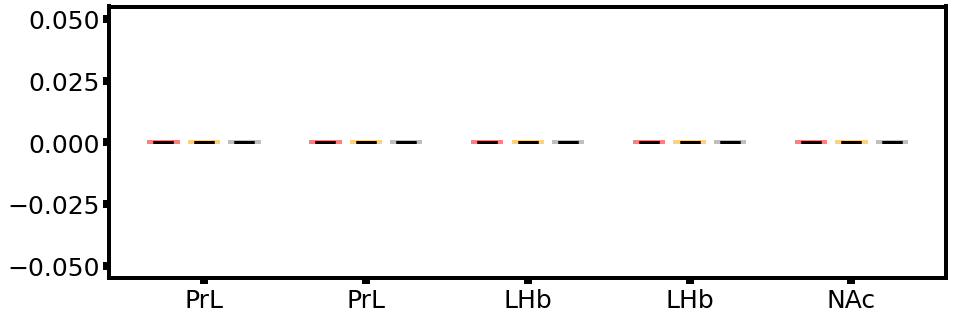

In [417]:
plt.figure(figsize=(15, 5))
plt.bar([0, 4, 8, 12, 16], np.nanmean(agg_R2_values, axis=0), alpha=0.5, color='white', edgecolor='red', linewidth=4, yerr=sem(agg_R2_values, axis=0, nan_policy='omit'), error_kw={'capsize': 10, 'elinewidth': 3, 'capthick': 3})
plt.bar([1, 5, 9, 13, 17], np.nanmean(obs_R2_values, axis=0), alpha=0.5, color='white', edgecolor='orange', linewidth=4, yerr=sem(obs_R2_values, axis=0, nan_policy='omit'), error_kw={'capsize': 10, 'elinewidth': 3, 'capthick': 3})
plt.bar([2, 6, 10, 14, 18], np.nanmean(non_R2_values, axis=0), alpha=0.5, color='white', edgecolor='gray', linewidth=4, yerr=sem(non_R2_values, axis=0, nan_policy='omit'), error_kw={'capsize': 10, 'elinewidth': 3, 'capthick': 3})
plt.xticks([1, 5, 9, 13, 17], ['PrL', 'PrL', 'LHb', 'LHb', 'NAc']);



In [230]:
groups = [agg_activity, obs_activity, non_activity]

# Function to perform regression and calculate accuracy
def perform_regression(group_data):
    X = group_data[:-1]  # All but the last timepoint
    y = group_data[-1].reshape(-1,1).T   # All but the first timepoint
    
    model = LinearRegression()
        model.fit(X_subject, y_subject)
        
        y_pred = model.predict(X_subject)
        
        accuracy = r2_score(y_subject, y_pred)
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

# Perform regression for each group and compare accuracies
accuracies = []

for i, group in enumerate(groups):
    accuracy = perform_regression(group)
    accuracies.append(accuracy)
    print(f'Group {i+1} Accuracy (R²): {accuracy:.2f}')

# Compare accuracies
best_group = np.argmax(accuracies) + 1
print(f'The group with the best prediction accuracy is Group {best_group}')

ValueError: Expected 2D array, got 1D array instead:
array=[0.185  0.3926 0.3271 0.7358 1.1262 0.6568 0.8018 0.2492 0.4086 0.6111
 0.6287 0.4417 0.6179 0.44   0.5333 0.4493 0.6856 0.6155 0.0653 0.5027
 0.3373 0.5412 0.7008 0.6554].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

(24, 22)

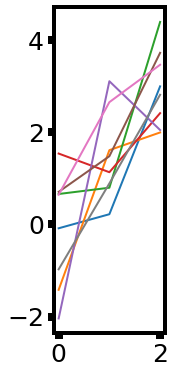

In [392]:

lines = []
num_points = 3
for i in range(8):
    # Generate a line with 3 points
    line = np.linspace(0, 3, num_points)

    # Add noise to the line
    noise = np.random.normal(0, 1, num_points)  # Noise with mean 0 and standard deviation 0.03
    line += noise

    # if i >= 6:
    #     line = np.flip(line)

    # Add the line to the list
    lines.append(line)

# Plot the lines
plt.figure(figsize=(2, 6))
for i, line in enumerate(lines):
    plt.plot(line, label=f'Line {i+1}', linewidth=2)
# plt.legend()
plt.show()
signals=lines

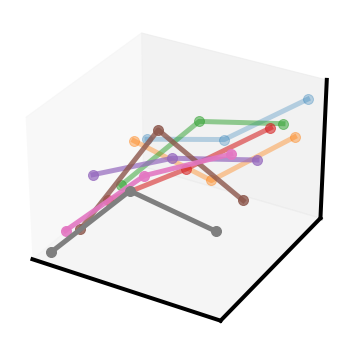

In [310]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(num_points)

for i, signal in reversed(list(enumerate(signals))):
    y = np.full(num_points, i)  # Create a 'y' array filled with the current index
    ax.plot(x, y, signal, alpha=1-(i*0.1), linewidth=5, marker='o', markersize=10)
# plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.plot([50, 50], [0, num_signals-1], [0, 0], color='red', linewidth=20)
plt.savefig('.\\retreat_figs\\signals.svg', dpi=300, bbox_inches='tight')

In [325]:
# Create a time vector
time = np.arange(24)

# Create the second time series
series1 = time / 24 * 10

series2 = np.zeros_like(time, dtype=float)
for i in range(0, len(time), 3):
    series2[i:i+3] = i / 24 * 6
    if i+3 < len(time):
        series2[i+3] += i / 24

series3 = np.zeros_like(time, dtype=float)
for i in range(0, len(time)):
    series3[i] = i % 3 / 2

series4 = np.zeros_like(time, dtype=float)
for i in range(0, len(time), 3):
    series4[i:i+3] = -i / 24 * 6
    if i+3 < len(time):
        series4[i+3] -= i / 24

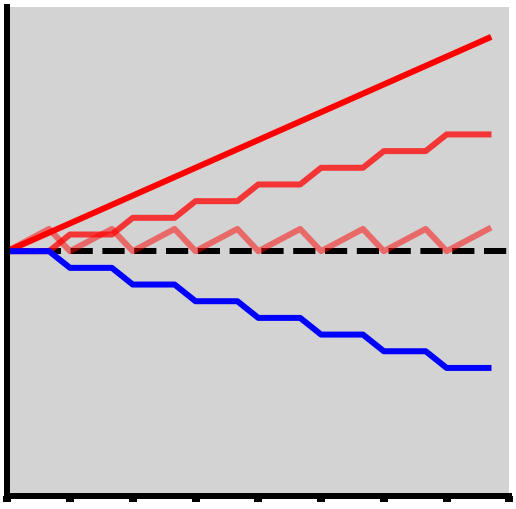

In [327]:
# Create an empty figure
fig, ax = plt.subplots(figsize=(9, 9))

# Formatting
ax.set_facecolor('lightgray')
ax.yaxis.set_tick_params(length=0)
plt.yticks([])
ax.set_xticklabels([])
# ax.set_xticklabels(['Day ' + str(i) for i in range(1, 10)], font='Arial', fontsize=50)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)
ax.set_xlim(0.5, 9.5)
sns.despine()
# ax.set_ylim(-5, 5)
plt.axhline(0, color='black', linewidth=6, linestyle='--')
# Plot the first time series
ax.plot(time, series1, color='red', linewidth=6, alpha=1)
ax.plot(time, series2, color='red', linewidth=6, alpha=0.75)
ax.plot(time, series3, color='red', linewidth=6, alpha=0.5)
ax.plot(time, series4, color='blue', linewidth=6, alpha=1)
ax.set_xticks(np.arange(0, 27, 3), np.arange(1, 10))
ax.set_xticklabels([])
ax.set_ylim(top=11, bottom=-11)



plt.savefig('.\\retreat_figs\\agg_balance_schematic.svg', dpi=300, bbox_inches='tight')
plt.show()

In [224]:
series3 = np.zeros_like(time, dtype=float)
for i in range(0, len(time), 3):
    series3[i:i+3] = i / 24 * 6
    if i+3 < len(time):
        series3[i+3] += i / 24

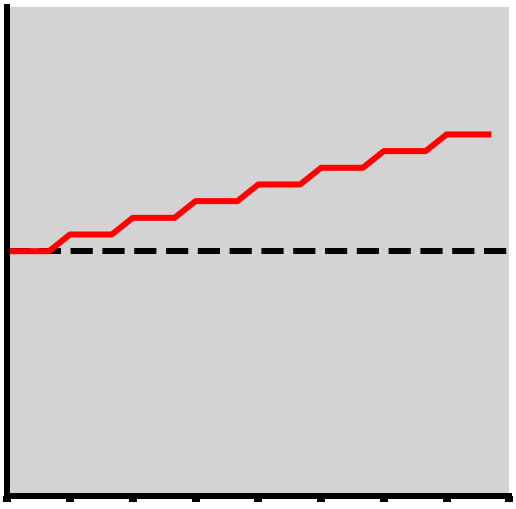

In [226]:
# Create an empty figure
fig, ax = plt.subplots(figsize=(9, 9))

# Formatting
ax.set_facecolor('lightgray')
ax.yaxis.set_tick_params(length=0)
plt.yticks([])
ax.set_xticklabels([])
# ax.set_xticklabels(['Day ' + str(i) for i in range(1, 10)], font='Arial', fontsize=50)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)
ax.set_xlim(0.5, 9.5)
sns.despine()
# ax.set_ylim(-5, 5)
plt.axhline(0, color='black', linewidth=6, linestyle='--')
# Plot the first time series
ax.plot(time, series3, color='red', linewidth=6, alpha=1)
ax.set_xticks(np.arange(0, 27, 3), np.arange(1, 10))
ax.set_xticklabels([])
ax.set_ylim(top=11, bottom=-11)
plt.savefig('.\\retreat_figs\\obs_balance_schematic.svg', dpi=300, bbox_inches='tight')
plt.show()